# This notebook contains the components (using gdsfactory) needed for making the Photonic Ising Chip

In [1]:
import gdsfactory as gf
import numpy as np
from gdsfactory.generic_tech.layer_map import LAYER
from gdsfactory.technology import LayerLevel, LayerStack

2023-09-16 21:46:22.708 | INFO     | gdsfactory.config:__init__:214 - LogLevel: INFO


## The Tunable element

### The pn should be reverse biased. So p should be connected to ground

In [4]:
import gdsfactory as gf


waveguide_width=0.5

@gf.cell
def tunable_unit(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, dc_io_arm_length=30.0, dual_modulation=True, modulator_type='eo', modulator_gap_length=50.0,eo_length=100.0, to_length=50.0):
    '''
    waveguide_width: (float) the width of the waveguide
    dual_modulation: (bool) if True, then phase shifters will be present in both the arms, else just one arm
    arm_length: (float) lengths of the arms
    dc_io_arm_length: (float) the input/output arm length og the directional coupler
    modulator_type: (string) eo: electro-optic, to: thermo-optic, both: eo followed by to
    modulator_gap: (float) when modulator_type='both' then the gam between the eo and to
    '''
    
    tu = gf.Component('photonic 2x2 tunable element')
    dc_3db=gf.components.coupler(gap=0.236, length=20.0, dy=arm_gap, dx=dc_io_arm_length, cross_section='strip', width=waveguide_width) #keep random params, but eventually it will be for 3dB

    ta=gf.components.straight(width=waveguide_width,length=arm_length)
    ba=gf.components.straight(width=waveguide_width,length=arm_length)

    if (modulator_type=='both'):

        ta=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)
        ba=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)

        to = gf.components.straight_heater_metal(length=to_length)
        eo = gf.components.straight_pn(length=eo_length, via_stack_width=10.0, via_stack_spacing=2)
        gap_strip=gf.components.straight(width=waveguide_width,length= modulator_gap_length)


        arm_top = gf.Component("atop arm")
        arm_to_top = arm_top << to
        arm_eo_top = arm_top << eo
        arm_gap_strip = arm_top << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_eo_top.ports['o2'])
        arm_to_top.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_top.add_port("o1", port=arm_eo_top.ports["o1"])
        arm_top.add_port("o2", port=arm_to_top.ports["o2"])

        arm_bottom = gf.Component("bottom arm")
        arm_to_bot = arm_bottom << to
        arm_eo_bot = arm_bottom << eo
        arm_gap_strip = arm_bottom << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_to_bot.ports['o2'])
        arm_eo_bot.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_bottom.add_port("o1", port=arm_to_bot.ports["o1"])
        arm_bottom.add_port("o2", port=arm_eo_bot.ports["o2"])

        # adding electrical ports for the thermo-optic shifter


        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_bot.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_top.ports[side + "_e" + str(port)] )

        
        # adding electrical ports for the electro-optic shifters
  
        doping=['p','n']
        
        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_bot.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_top.ports[prefix + "_e" + str(port)] )
    
        # the port naming is correct for the top and bottom arm. I have verified it.
        # difference with the others is that they were first connected and then the ports were added








        ta=arm_top

        if (dual_modulation==True):
            ba=arm_bottom

   

    if (modulator_type=='eo'):
        arm=gf.components.straight_pn(length=arm_length, via_stack_width=10.0, via_stack_spacing=2)

        ta=arm

        if (dual_modulation==True):
            ba=arm



    if (modulator_type=='to'):
        arm=gf.components.straight_heater_metal(length=arm_length)

        ta=arm

        if (dual_modulation==True):
            ba=arm
    



    dc1=tu << dc_3db
    top_arm= tu << ta
    bottom_arm = tu << ba
    dc2= tu << dc_3db
 
    # dc1.connect(port="o3", destination=top_arm.ports["o1"])
    # dc1.connect(port="o4", destination=bottom_arm.ports["o1"])
    #dc2.connect(port="o2", destination=top_arm.ports["o2"])
    #dc2.connect(port="o1", destination=bottom_arm.ports["o2"])

    # top_arm.connect(port='o1',destination=dc1.ports['o3'])
    # bottom_arm.connect(port='o1',destination=dc2.ports['o4'])
    # dc2.connect(port='o1',destination=bottom_arm.ports['o2'])
    # dc2.connect(port='o2',destination=top_arm.ports['o2'])

    top_arm.connect(port='o1',destination=dc1.ports['o3'])
    dc2.connect(port='o2',destination=top_arm.ports['o2']) 
    
    bottom_arm.connect(port='o1',destination=dc2.ports['o1'])
    bottom_arm.connect(port='o2',destination=dc1.ports['o4'])
    #dc1.connect(port='o4',destination=bottom_arm.ports['o2'])
       

    tu.add_port("o1", port=dc1.ports["o1"])
    tu.add_port("o2", port=dc1.ports["o2"])
    tu.add_port("o3", port=dc2.ports["o3"])
    tu.add_port("o4", port=dc2.ports["o4"])

    if (modulator_type=='to'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =bottom_arm.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        tu.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =top_arm.ports[side + "_e" + str(port)] )


                   

    if (modulator_type=='eo'):

        doping=['p','n']
        

        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =bottom_arm.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        tu.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =top_arm.ports[prefix + "_e" + str(port)] )
    

    if (modulator_type=='both'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port('to_' +heater + side+"_e"+str(port), port =bottom_arm.ports['to_' +heater + side+"_e"+str(port)] )

                    else:
                        tu.add_port('to_' +heater + side+"_e"+str(port), port =top_arm.ports['to_' +heater + side+"_e"+str(port)] )



        for mod in ['t','b']:
            for d in doping:
                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port('eo_' +mod + d+"_e"+str(port), port =bottom_arm.ports['eo_' +mod + d+"_e"+str(port)] )

                    else:
                        tu.add_port('eo_' +mod + d+"_e"+str(port), port =top_arm.ports['eo_' +mod + d+"_e"+str(port)] )
    



    return tu



# Test codes

# k=2

# a=['1','2','3','4']
# #a.index('1')
# for i in  range(len(a)):
#     print(k%len(a))
#     k=k+1

# sides=['l','r']
# for side in sides:
#     print(side,sides[(sides.index(side)+1)%len(sides)])

# k=2
# for port in range(1,5):
#     print(port, (k+port-1)%len(range(1,5))+1)
# doping=['p','n']
# for d in doping:
#     print("top" if d=='p' else "bot")


### Visualization

In [5]:
c1=tunable_unit(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, dc_io_arm_length=30.0, dual_modulation=True, modulator_type='to', modulator_gap_length=30.0,eo_length=100.0, to_length=50.0)
c1.plot()

INFO:     Started server process [18133]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://localhost:8000 (Press CTRL+C to quit)


In [6]:

c1_pad = gf.routing.add_pads_bot(component=c1, port_names=("to_tl_e2", "to_tr_e2", "to_bl_e4", "to_br_e4"), fanout_length=50)
c1_pad.plot()

INFO:     127.0.0.1:57150 - "GET /gds?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_cff3633f_a_b3438371.gds&layer_props=/tmp/gdsfactory/layers.lyp HTTP/1.1" 200 OK
INFO:     127.0.0.1:57150 - "GET /client.css HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:57156 - "GET /client.js HTTP/1.1" 304 Not Modified


INFO:     ('127.0.0.1', 57170) - "WebSocket /gds/ws?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_cff3633f_a_b3438371.gds&layer_props=/tmp/gdsfactory/layers.lyp" [accepted]
INFO:     connection open


In [7]:
c1_pad.ports

{'o1': {'name': 'o1', 'width': 0.5, 'center': [-30.0, -24.632], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o2': {'name': 'o2', 'width': 0.5, 'center': [-30.0, 25.368], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o3': {'name': 'o3', 'width': 0.5, 'center': [230.0, 25.368], 'orientation': 0.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o4': {'name': 'o4', 'width': 0.5, 'center': [230.0, -24.632], 'orientation': 0.0, 'layer': [1, 0], 'port_type': 'optical'},
 'to_tl_e1': {'name': 'to_tl_e1', 'width': 11.0, 'center': [34.0, 25.368], 'orientation': 180.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tl_e2': {'name': 'to_tl_e2', 'width': 11.0, 'center': [39.5, 30.868], 'orientation': 90.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tl_e3': {'name': 'to_tl_e3', 'width': 11.0, 'center': [45.0, 25.368], 'orientation': 0.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tl_e4': {'name': 'to_tl_e4', 'width': 11.0, 'center': [39.5, 19

In [ ]:
c1_3d=c1_pad.to_3d()
c1_3d.show()

In [ ]:
c2=tunable_unit(waveguide_width=0.5, arm_length=1000.0, arm_gap=100.0, dc_io_arm_length=100.0, dual_modulation=True, modulator_type='eo', modulator_gap_length=30.0,eo_length=100.0, to_length=50.0)
c2.plot()

INFO:     127.0.0.1:46266 - "GET /gds?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_16254e47.gds&layer_props=/tmp/gdsfactory/layers.lyp HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 46280) - "WebSocket /gds/ws?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_16254e47.gds&layer_props=/tmp/gdsfactory/layers.lyp" [accepted]
INFO:     connection open


In [9]:
c2.ports

{'o1': {'name': 'o1', 'width': 0.5, 'center': [-100.0, -49.632], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o2': {'name': 'o2', 'width': 0.5, 'center': [-100.0, 50.368], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o3': {'name': 'o3', 'width': 0.5, 'center': [1340.0, 50.368], 'orientation': 0.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o4': {'name': 'o4', 'width': 0.5, 'center': [1340.0, -49.632], 'orientation': 0.0, 'layer': [1, 0], 'port_type': 'optical'},
 'eo_tp_e1': {'name': 'eo_tp_e1', 'width': 10.0, 'center': [130.0, 56.368], 'orientation': 180.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'eo_tp_e2': {'name': 'eo_tp_e2', 'width': 980.0, 'center': [620.0, 61.368], 'orientation': 90.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'eo_tp_e3': {'name': 'eo_tp_e3', 'width': 10.0, 'center': [1110.0, 56.368], 'orientation': 0.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'eo_tp_e4': {'name': 'eo_tp_e4', 'width': 980.0, 'center':

In [ ]:
c2_pad = gf.routing.add_pads_bot(component=c2, port_names=("eo_bp_e1","eo_bp_e3","eo_bn_e1","eo_bn_e3","eo_tp_e1","eo_tp_e3","eo_tn_e1","eo_tn_e3"), fanout_length=50)
c2_pad.plot()

INFO:     127.0.0.1:40310 - "GET /gds?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_16254e47_a_b8ce3a6c.gds&layer_props=/tmp/gdsfactory/layers.lyp HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 40322) - "WebSocket /gds/ws?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_16254e47_a_b8ce3a6c.gds&layer_props=/tmp/gdsfactory/layers.lyp" [accepted]
INFO:     connection open


In [ ]:
c2_3d=c2_pad.to_3d()
c2_3d.show()

In [ ]:
c3=tunable_unit(waveguide_width=0.5, arm_length=100.0, arm_gap=60.0, dc_io_arm_length=30.0, dual_modulation=True, modulator_type='both', modulator_gap_length=100.0,eo_length=200.0, to_length=200.0)
c3.plot()

2023-09-16 21:49:21.129 | WARNING  | gdsfactory.components.bend_s:bend_s:59 - The min bend radius of the generated s bend 9.885 is below the bend radius of the waveguide 10.0


INFO:     127.0.0.1:40332 - "GET /gds?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_c6ec4412.gds&layer_props=/tmp/gdsfactory/layers.lyp HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 40344) - "WebSocket /gds/ws?gds_file=/home/satadrudas/.gdsfactory/extra/tunable_unit_c6ec4412.gds&layer_props=/tmp/gdsfactory/layers.lyp" [accepted]
INFO:     connection open


In [ ]:
c3_3d=c3.to_3d()
c3_3d.show()

In [12]:
c3_pad = gf.routing.add_pads_bot(component=c3, port_names=("eo_tp_e1","eo_tp_e4","eo_tn_e1","eo_tn_e4"), fanout_length=50)
c3_pad.plot()

In [13]:
c3_pad = gf.routing.add_pads_bot(component=c3, port_names=("eo_bp_e1","eo_bp_e4","eo_bn_e1","eo_bn_e4","eo_tp_e1","eo_tp_e4","eo_tn_e1","eo_tn_e4","to_tl_e4", "to_tr_e3", "to_bl_e4", "to_br_e4"), fanout_length=50)
c3_pad.plot()

In [ ]:
c3_3d=c3_pad.to_3d()
c3_3d.show()

## Y Splitter

In [15]:
import gdsfactory as gf


import gdsfactory as gf


@gf.cell
#def y_splitter(arm_gap=20.0, dx=10.0, dx_input=10.0, sbend_x=10.0):

def y_splitter(
    arm_gap: float = 20.0,
    dx: float = 10.0,
    dx_input: float = 10.0,
    sbend_x: float = 10.0,
    sbend: gf.typings.ComponentSpec = gf.components.bend_s,
    mmi1x2: gf.typings.ComponentSpec = gf.components.mmi1x2_with_sbend,
    waveguide_extend: gf.typings.ComponentSpec = gf.components.straight,
    **kwargs,
) -> gf.component.Component:

    mid_section_gap=7.0

    s_bend=gf.get_component(sbend,size=[sbend_x, (arm_gap-mid_section_gap)/2], npoints=99, cross_section='strip', check_min_radius=False )#gf.components.bend_s(size=[sbend_x, (arm_gap-mid_section_gap)/2], npoints=99, cross_section='strip', check_min_radius=False)
    op_wg_extend=gf.get_component(waveguide_extend,length=dx)
    ip_wg_extend=gf.get_component(waveguide_extend,length=dx_input)

    y_splitter=gf.Component("y splitter")



    splitter = y_splitter << gf.get_component(mmi1x2, with_sbend=False, cross_section='strip')#gf.components.mmi1x2_with_sbend(with_sbend=False, cross_section='strip')
    top_s = y_splitter << s_bend
    bot_s = y_splitter <<s_bend.mirror()

    input_wg = y_splitter << ip_wg_extend
    output_wg1 = y_splitter << op_wg_extend
    output_wg2 = y_splitter << op_wg_extend

    splitter.connect(port='o1',destination=input_wg.ports['o2'])

    top_s.connect(port='o1', destination=splitter.ports['o2'])
    bot_s.connect(port='o2', destination=splitter.ports['o3'])

    
    output_wg1.connect(port='o1', destination=top_s.ports['o2'])
    output_wg2.connect(port='o1', destination=bot_s.ports['o1'])

    # adding ports

    y_splitter.add_port('o1',port=input_wg.ports["o1"])
    y_splitter.add_port('o2',port=output_wg1.ports["o2"])
    y_splitter.add_port('o3',port=output_wg2.ports["o2"])


    return y_splitter



### Visualization

In [16]:
c=y_splitter(arm_gap=20)
c=c.mirror()
c.plot()

2023-09-16 21:50:14.352 | WARNING  | gdsfactory.components.bend_s:bend_s:59 - The min bend radius of the generated s bend 4.422 is below the bend radius of the waveguide 10.0


In [17]:
c.ports

{'o1': {'name': 'o1', 'width': 0.5, 'center': [0.0, 0.0], 'orientation': 0.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o2': {'name': 'o2', 'width': 0.5, 'center': [-32.5, 6.85], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o3': {'name': 'o3', 'width': 0.5, 'center': [-32.5, -6.85], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'}}

## MZM

### The pn should be reverse biased. So p should be connected to ground

In [18]:
import gdsfactory as gf



import gdsfactory as gf

@gf.cell
def y_splitter(
    arm_gap: float = 20.0,
    dx: float = 10.0,
    dx_input: float = 10.0,
    sbend_x: float = 10.0,
    sbend: gf.typings.ComponentSpec = gf.components.bend_s,
    mmi1x2: gf.typings.ComponentSpec = gf.components.mmi1x2_with_sbend,
    **kwargs,
) -> gf.component.Component:

    mid_section_gap=7.0

    s_bend=gf.get_component(sbend,size=[sbend_x, (arm_gap-mid_section_gap)/2], npoints=99, cross_section='strip', check_min_radius=False )#gf.components.bend_s(size=[sbend_x, (arm_gap-mid_section_gap)/2], npoints=99, cross_section='strip', check_min_radius=False)

    y_splitter=gf.Component("y splitter")

    splitter = y_splitter << gf.get_component(mmi1x2, with_sbend=False, cross_section='strip')#gf.components.mmi1x2_with_sbend(with_sbend=False, cross_section='strip')
    top_s = y_splitter << s_bend
    bot_s = y_splitter <<s_bend.mirror()

    top_s.connect(port='o1', destination=splitter.ports['o2'])
    bot_s.connect(port='o2', destination=splitter.ports['o3'])

    # adding ports

    y_splitter.add_port('o1',port=splitter.ports["o1"])
    y_splitter.add_port('o2',port=top_s.ports["o2"])
    y_splitter.add_port('o3',port=bot_s.ports["o1"])

    # y_splitter = gf.components.extension.extend_ports(component=y_splitter, port_names=('o2',), length=dx)
    # y_splitter = gf.components.extension.extend_ports(component=y_splitter, port_names=('o3',), length=dx)
    #y_splitter = gf.components.extension.extend_ports(component=y_splitter, port_names=('o1',), length=dx_input)


    return y_splitter




waveguide_width=0.5

@gf.cell
def mzm(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, ys_op_arm_length=10.0 , ys_ip_arm_length=10.0, sbend_x=10.0, dual_modulation=True, modulator_type='eo', modulator_gap_length=50.0,eo_length=100.0, to_length=50.0):
    '''
    waveguide_width: (float) the width of the waveguide
    dual_modulation: (bool) if True, then phase shifters will be present in both the arms, else just one arm
    arm_length: (float) lengths of the arms
    dc_io_arm_length: (float) the input/output arm length og the directional coupler
    modulator_type: (string) eo: electro-optic, to: thermo-optic, both: eo followed by to
    modulator_gap: (float) when modulator_type='both' then the gam between the eo and to
    '''
    
    mzm = gf.Component('mzm')
    ys=y_splitter(arm_gap=arm_gap, dx=ys_op_arm_length, dx_input=ys_ip_arm_length, sbend_x=sbend_x)

    ta=gf.components.straight(width=waveguide_width,length=arm_length)
    ba=gf.components.straight(width=waveguide_width,length=arm_length)

    if (modulator_type=='both'):

        ta=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)
        ba=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)

        to = gf.components.straight_heater_metal(length=to_length)
        eo = gf.components.straight_pn(length=eo_length, via_stack_width=10.0, via_stack_spacing=2)
        gap_strip=gf.components.straight(width=waveguide_width,length= modulator_gap_length)


        arm_top = gf.Component("atop arm")
        arm_to_top = arm_top << to
        arm_eo_top = arm_top << eo
        arm_gap_strip = arm_top << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_eo_top.ports['o2'])
        arm_to_top.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_top.add_port("o1", port=arm_eo_top.ports["o1"])
        arm_top.add_port("o2", port=arm_to_top.ports["o2"])

        arm_bottom = gf.Component("bottom arm")
        arm_to_bot = arm_bottom << to
        arm_eo_bot = arm_bottom << eo
        arm_gap_strip = arm_bottom << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_to_bot.ports['o2'])
        arm_eo_bot.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_bottom.add_port("o1", port=arm_to_bot.ports["o1"])
        arm_bottom.add_port("o2", port=arm_eo_bot.ports["o2"])

        # adding electrical ports for the thermo-optic shifter


        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_bot.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_top.ports[side + "_e" + str(port)] )

        
        # adding electrical ports for the electro-optic shifters
  
        doping=['p','n']
        
        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_bot.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_top.ports[prefix + "_e" + str(port)] )
    
        # the port naming is correct for the top and bottom arm. I have verified it.
        # difference with the others is that they were first connected and then the ports were added








        ta=arm_top

        if (dual_modulation==True):
            ba=arm_bottom

   

    if (modulator_type=='eo'):
        arm=gf.components.straight_pn(length=arm_length, via_stack_width=10.0, via_stack_spacing=2)

        ta=arm

        if (dual_modulation==True):
            ba=arm



    if (modulator_type=='to'):
        arm=gf.components.straight_heater_metal(length=arm_length)

        ta=arm

        if (dual_modulation==True):
            ba=arm
    



    left_y_splitter=mzm << ys
    top_arm= mzm << ta
    bottom_arm = mzm << ba
    right_y_splitter= mzm << ys.mirror()
 


    top_arm.connect(port='o1',destination=left_y_splitter.ports['o2'])
    right_y_splitter.connect(port='o2', destination=top_arm.ports['o2'])

    bottom_arm.connect(port='o1',destination=right_y_splitter.ports['o3'])
    bottom_arm.connect(port='o2',destination=left_y_splitter.ports['o3'])





    # top_arm.connect(port='o2',destination=right_y_splitter.ports['o2'])
    
    # bottom_arm.connect(port='o1',destination=right_y_splitter.ports['o3'])
    # bottom_arm.connect(port='o2',destination=left_y_splitter.ports['o3'])
    #dc1.connect(port='o4',destination=bottom_arm.ports['o2'])
       

    mzm.add_port("o1", port=left_y_splitter.ports["o1"])
    mzm.add_port("o2", port=right_y_splitter.ports["o1"])


    if (modulator_type=='to'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =bottom_arm.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        mzm.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =top_arm.ports[side + "_e" + str(port)] )


                   

    if (modulator_type=='eo'):

        doping=['p','n']
        

        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =bottom_arm.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        mzm.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =top_arm.ports[prefix + "_e" + str(port)] )
    

    if (modulator_type=='both'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port('to_' +heater + side+"_e"+str(port), port =bottom_arm.ports['to_' +heater + side+"_e"+str(port)] )

                    else:
                        mzm.add_port('to_' +heater + side+"_e"+str(port), port =top_arm.ports['to_' +heater + side+"_e"+str(port)] )



        for mod in ['t','b']:
            for d in doping:
                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port('eo_' +mod + d+"_e"+str(port), port =bottom_arm.ports['eo_' +mod + d+"_e"+str(port)] )

                    else:
                        mzm.add_port('eo_' +mod + d+"_e"+str(port), port =top_arm.ports['eo_' +mod + d+"_e"+str(port)] )



    # connecting the ground ports


    if (modulator_type=='to' or modulator_type=='both') and (dual_modulation == True):
        route = gf.routing.get_route_electrical(mzm.ports["to_tl_e4"], mzm.ports["to_br_e2"], bend="wire_corner")
        mzm.add(route.references)

            

    



    return mzm



# Test codes

# k=2

# a=['1','2','3','4']
# #a.index('1')
# for i in  range(len(a)):
#     print(k%len(a))
#     k=k+1

# sides=['l','r']
# for side in sides:
#     print(side,sides[(sides.index(side)+1)%len(sides)])

# k=2
# for port in range(1,5):
#     print(port, (k+port-1)%len(range(1,5))+1)
# doping=['p','n']
# for d in doping:
#     print("top" if d=='p' else "bot")


### Visualization

In [19]:
c1=mzm(waveguide_width=0.5, arm_length=10.0, arm_gap=50.0, ys_op_arm_length=10.0 , ys_ip_arm_length=10.0, sbend_x=10.0, dual_modulation=True, modulator_type='to', modulator_gap_length=50.0,eo_length=100.0, to_length=50.0)
c1.plot()

2023-09-16 21:50:32.261 | WARNING  | gdsfactory.components.bend_s:bend_s:59 - The min bend radius of the generated s bend 1.687 is below the bend radius of the waveguide 10.0


In [20]:
c1.ports

{'o1': {'name': 'o1', 'width': 0.5, 'center': [-0.25, 0.0], 'orientation': 180.0, 'layer': [1, 0], 'port_type': 'optical'},
 'o2': {'name': 'o2', 'width': 0.5, 'center': [70.75, 0.0], 'orientation': 0.0, 'layer': [1, 0], 'port_type': 'optical'},
 'to_tl_e1': {'name': 'to_tl_e1', 'width': 11.0, 'center': [-3.75, 21.85], 'orientation': 180.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tl_e2': {'name': 'to_tl_e2', 'width': 11.0, 'center': [1.75, 27.35], 'orientation': 90.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tl_e3': {'name': 'to_tl_e3', 'width': 11.0, 'center': [7.25, 21.85], 'orientation': 0.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tl_e4': {'name': 'to_tl_e4', 'width': 11.0, 'center': [1.75, 16.35], 'orientation': 270.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tr_e1': {'name': 'to_tr_e1', 'width': 11.0, 'center': [63.25, 21.85], 'orientation': 180.0, 'layer': [49, 0], 'port_type': 'electrical'},
 'to_tr_e2': {'name': 'to_tr_e2', 'width': 11

In [21]:

c1_pad = gf.routing.add_pads_bot(component=c1, port_names=("to_tl_e2", "to_tr_e2", "to_bl_e4", "to_br_e4"), fanout_length=50)
c1_pad.plot()

In [ ]:
c1_pad.ports

In [ ]:
c1_3d=c1_pad.to_3d()
c1_3d.show()

In [ ]:
c2=mzm(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, ys_op_arm_length=10.0 , ys_ip_arm_length=10.0, sbend_x=10.0, dual_modulation=True, modulator_type='eo', modulator_gap_length=50.0,eo_length=100.0, to_length=50.0)
c2.plot()

In [ ]:
c2.ports

In [ ]:
c2_pad = gf.routing.add_pads_bot(component=c2, port_names=("eo_bp_e1","eo_bp_e3","eo_bn_e1","eo_bn_e3","eo_tp_e1","eo_tp_e3","eo_tn_e1","eo_tn_e3"), fanout_length=50)
c2_pad.plot()

In [ ]:
c2_3d=c2_pad.to_3d()
c2_3d.show()

In [ ]:
c3=mzm(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, ys_op_arm_length=10.0 , ys_ip_arm_length=10.0, sbend_x=10.0, dual_modulation=True, modulator_type='both', modulator_gap_length=50.0,eo_length=100.0, to_length=200.0)

c3.plot()

In [ ]:
c3.ports

In [ ]:
j=gf.Component()
a=j << c3
route = gf.routing.get_route_electrical(
    a.ports["to_tl_e1"], a.ports["to_br_e3"], bend="wire_corner"
)
c3.add(route.references)
c3.plot()

In [ ]:
route = gf.routing.get_route_electrical(
    c3.ports["to_tl_e1"], c3.ports["to_br_e3"], bend="wire_corner"
)
c3.add(route.references)
c3.plot()

In [ ]:
c3_3d=c3.to_3d()
c3_3d.show()

In [ ]:
c3_pad = gf.routing.add_pads_bot(component=c3, port_names=("eo_tp_e1","eo_tp_e2","eo_bn_e1","eo_bn_e4"), fanout_length=50)
c3_pad.plot()

In [ ]:
c3_pad = gf.routing.add_pads_bot(component=c3, port_names=("eo_bp_e1","eo_bp_e4","eo_bn_e1","eo_bn_e4","eo_tp_e1","eo_tp_e4","eo_tn_e1","eo_tn_e4","to_tl_e4", "to_tr_e3", "to_bl_e4", "to_br_e4"), fanout_length=50)
c3_pad.plot()

In [ ]:
c3_3d=c3_pad.to_3d()
c3_3d.show()

## Detectors

## Photonic Isinch Chip 

In [22]:
import gdsfactory as gf


@gf.cell
def PIM_single_unit(gap_between_modulators: float = 60.0,
    min_bend_radius: float = 10.0,
    tu_arm_length: float = 100.0,
    tu_mod_type: str = 'to',
    modulator_gap_length: float =50.0,
    mod_sbend_x: float = 30.0,
    mod_arm_gap: float = 50.0,
    mod_arm_length: float= 100.0,
    mod_type: str = "both",
    eo_length: float =100.0, 
    to_length:float =50.0,
    splitter_sbend_x: float = 30.0,
    split_op_extend: float = 10.0,
    input:  gf.typings.ComponentSpec = gf.components.grating_coupler_elliptical,
    splitter: gf.typings.ComponentSpec = y_splitter,
    detector: gf.typings.ComponentSpec = gf.components.ge_detector_straight_si_contacts,
    mzm: gf.typings.ComponentSpec =mzm,
    tunable_element: gf.typings.ComponentSpec = tunable_unit,
):
    pim1=gf.Component("Single unit of the PIM")

    input0 = gf.get_component(input)
    detector = gf.get_component(detector)#gf.components.ge_detector_straight_si_contacts(length=80.0, via_stack_width=10.0, via_stack_spacing=5.0, via_stack_offset=0.0)
    tu = gf.get_component(tunable_element, arm_length=tu_arm_length,modulator_type=tu_mod_type)
    mzm0 = gf.get_component(mzm, modulator_gap_length=modulator_gap_length,eo_length=eo_length, to_length=to_length, modulator_type=mod_type, arm_length=mod_arm_length,sbend_x=mod_sbend_x, arm_gap=mod_arm_gap)
    split = gf.get_component(splitter,arm_gap=gap_between_modulators,dx=split_op_extend, sbend_x=splitter_sbend_x)

    
    
    in_source = pim1 << input0.mirror()
    source_splitter = pim1 << split
    mzm1 = pim1 << mzm0
    mzm2 = pim1 << mzm0

    h = pim1 << tu
    h.move((1.5*(modulator_gap_length+eo_length+to_length+split_op_extend+ 2*mod_sbend_x+splitter_sbend_x),0))

    detector1 = pim1 << detector
    detector2 = pim1 << detector

    source_splitter.connect(port='o1', destination=in_source.ports['o1'])

    mzm1.connect(port='o1', destination=source_splitter.ports['o2'])
    mzm2.connect(port='o1', destination=source_splitter.ports['o3'])

    #h.connect(port='o2',destination=mzm1.ports['o2'])
    #h.connect(port='o1',destination=mzm2.ports['o2'])

    route_t = gf.routing.get_route(mzm1.ports['o2'], h.ports['o2'], radius=min_bend_radius)
    pim1.add(route_t.references)
    route_b = gf.routing.get_route(mzm2.ports['o2'], h.ports['o1'], radius=min_bend_radius)
    pim1.add(route_b.references)

    detector1.connect(port='o1',destination=h.ports['o3'])
    detector2.connect(port='o1',destination=h.ports['o4'])

    # Add electrical ports to mzm1
    for e_port in mzm1.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('mzm1_'+e_port, port=mzm1.ports[e_port])

    # Add electrical ports to mzm2
    for e_port in mzm2.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('mzm2_'+e_port, port=mzm2.ports[e_port])

    # Add electrical ports to h
    for e_port in h.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('tu_'+e_port, port=h.ports[e_port])

    # Add electrical ports to detector1
    for e_port in detector1.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('detector1_'+e_port, port=detector1.ports[e_port])

    # Add electrical ports to detector2
    for e_port in detector2.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('detector2_'+e_port, port=detector2.ports[e_port])

    

    return pim1

    

In [23]:
c=PIM_single_unit(gap_between_modulators=120)
c.plot()

2023-09-16 21:51:02.815 | WARNING  | gdsfactory.components.bend_s:bend_s:59 - The min bend radius of the generated s bend 5.715 is below the bend radius of the waveguide 10.0


In [24]:
import gdsfactory as gf


@gf.cell
def PIM_single_unit1(gap_between_modulators: float = 60.0,
    min_bend_radius: float = 10.0,
    tu_arm_length: float = 100.0,
    tu_mod_type: str = 'to',
    modulator_gap_length: float =50.0,
    mod_sbend_x: float = 30.0,
    mod_arm_gap: float = 50.0,
    mod_arm_length: float= 100.0,
    mod_type: str = "both",
    eo_length: float =100.0, 
    to_length:float =50.0,
    splitter_sbend_x: float = 30.0,
    split_op_extend: float = 10.0,
    straight: gf.typings.ComponentSpec = gf.components.straight,
    input:  gf.typings.ComponentSpec = gf.components.grating_coupler_elliptical,
    splitter: gf.typings.ComponentSpec = gf.components.mmi1x2_with_sbend, # replacing the splitter with mmi1x2_sbend
    detector: gf.typings.ComponentSpec = gf.components.ge_detector_straight_si_contacts,
    mzm: gf.typings.ComponentSpec =mzm,
    tunable_element: gf.typings.ComponentSpec = tunable_unit,
):
    pim1=gf.Component("Single unit of the PIM")

    mzm_length = modulator_gap_length+eo_length+to_length+ 2*mod_sbend_x

    input0 = gf.get_component(input)
    detector = gf.get_component(detector)#gf.components.ge_detector_straight_si_contacts(length=80.0, via_stack_width=10.0, via_stack_spacing=5.0, via_stack_offset=0.0)
    tu = gf.get_component(tunable_element, arm_length=tu_arm_length,modulator_type=tu_mod_type)
    mzm0 = gf.get_component(mzm, modulator_gap_length=modulator_gap_length,eo_length=eo_length, to_length=to_length, modulator_type=mod_type, arm_length=mod_arm_length,sbend_x=mod_sbend_x, arm_gap=mod_arm_gap)
    split = gf.get_component(splitter,with_sbend=True)
    straight = gf.get_component(straight, length=10.0)

    
    
    in_source = pim1 << input0.mirror()
    #straight_wg = pim1 << straight



    source_splitter = pim1 << split
    source_splitter.move((-mzm_length/4,0))

    mzm1 = pim1 << mzm0
    mzm1.move((0,gap_between_modulators/2))

    mzm2 = pim1 << mzm0
    mzm2.move((0,-gap_between_modulators/2))

    h = pim1 << tu
    h.move((1.5*(mzm_length),0))

    detector1 = pim1 << detector
    detector2 = pim1 << detector

    

    route_t1 = gf.routing.get_route(source_splitter.ports['o2'], mzm1.ports['o1'], radius=min_bend_radius)
    pim1.add(route_t1.references)
    route_b1 = gf.routing.get_route(source_splitter.ports['o3'], mzm2.ports['o1'], radius=min_bend_radius)
    pim1.add(route_b1.references)



    route_t = gf.routing.get_route(mzm1.ports['o2'], h.ports['o2'], radius=min_bend_radius)
    pim1.add(route_t.references)
    route_b = gf.routing.get_route(mzm2.ports['o2'], h.ports['o1'], radius=min_bend_radius)
    pim1.add(route_b.references)


    #source_splitter.connect(port='o1', destination=in_source.ports['o1'])
    in_source.connect(port='o1', destination=source_splitter.ports['o1'])

    detector1.connect(port='o1',destination=h.ports['o3'])
    detector2.connect(port='o1',destination=h.ports['o4'])

    # Add electrical ports to mzm1
    for e_port in mzm1.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('mzm1_'+e_port, port=mzm1.ports[e_port])

    # Add electrical ports to mzm2
    for e_port in mzm2.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('mzm2_'+e_port, port=mzm2.ports[e_port])

    # Add electrical ports to h
    for e_port in h.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('tu_'+e_port, port=h.ports[e_port])

    # Add electrical ports to detector1
    for e_port in detector1.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('detector1_'+e_port, port=detector1.ports[e_port])

    # Add electrical ports to detector2
    for e_port in detector2.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('detector2_'+e_port, port=detector2.ports[e_port])

    

    return pim1

    

In [25]:
c=PIM_single_unit1(gap_between_modulators=120,min_bend_radius=10)
c.plot()

## Final

In [2]:
import gdsfactory as gf


waveguide_width=0.5

import gdsfactory as gf


import gdsfactory as gf


@gf.cell
#def y_splitter(arm_gap=20.0, dx=10.0, dx_input=10.0, sbend_x=10.0):

def y_splitter(
    arm_gap: float = 20.0,
    dx: float = 10.0,
    dx_input: float = 10.0,
    sbend_x: float = 10.0,
    sbend: gf.typings.ComponentSpec = gf.components.bend_s,
    mmi1x2: gf.typings.ComponentSpec = gf.components.mmi1x2_with_sbend,
    waveguide_extend: gf.typings.ComponentSpec = gf.components.straight,
    **kwargs,
) -> gf.component.Component:

    mid_section_gap=7.0

    s_bend=gf.get_component(sbend,size=[sbend_x, (arm_gap-mid_section_gap)/2], npoints=99, cross_section='strip', check_min_radius=False )#gf.components.bend_s(size=[sbend_x, (arm_gap-mid_section_gap)/2], npoints=99, cross_section='strip', check_min_radius=False)
    op_wg_extend=gf.get_component(waveguide_extend,length=dx)
    ip_wg_extend=gf.get_component(waveguide_extend,length=dx_input)

    y_splitter=gf.Component("y splitter")



    splitter = y_splitter << gf.get_component(mmi1x2, with_sbend=False, cross_section='strip')#gf.components.mmi1x2_with_sbend(with_sbend=False, cross_section='strip')
    top_s = y_splitter << s_bend
    bot_s = y_splitter <<s_bend.mirror()

    input_wg = y_splitter << ip_wg_extend
    output_wg1 = y_splitter << op_wg_extend
    output_wg2 = y_splitter << op_wg_extend

    splitter.connect(port='o1',destination=input_wg.ports['o2'])

    top_s.connect(port='o1', destination=splitter.ports['o2'])
    bot_s.connect(port='o2', destination=splitter.ports['o3'])

    
    output_wg1.connect(port='o1', destination=top_s.ports['o2'])
    output_wg2.connect(port='o1', destination=bot_s.ports['o1'])

    # adding ports

    y_splitter.add_port('o1',port=input_wg.ports["o1"])
    y_splitter.add_port('o2',port=output_wg1.ports["o2"])
    y_splitter.add_port('o3',port=output_wg2.ports["o2"])


    return y_splitter



@gf.cell
def tunable_unit(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, dc_io_arm_length=30.0, dual_modulation=True, modulator_type='eo', modulator_gap_length=50.0,eo_length=100.0, to_length=50.0):
    '''
    waveguide_width: (float) the width of the waveguide
    dual_modulation: (bool) if True, then phase shifters will be present in both the arms, else just one arm
    arm_length: (float) lengths of the arms
    dc_io_arm_length: (float) the input/output arm length og the directional coupler
    modulator_type: (string) eo: electro-optic, to: thermo-optic, both: eo followed by to
    modulator_gap: (float) when modulator_type='both' then the gam between the eo and to
    '''
    
    tu = gf.Component('photonic 2x2 tunable element')
    dc_3db=gf.components.coupler(gap=0.236, length=20.0, dy=arm_gap, dx=dc_io_arm_length, cross_section='strip', width=waveguide_width) #keep random params, but eventually it will be for 3dB

    ta=gf.components.straight(width=waveguide_width,length=arm_length)
    ba=gf.components.straight(width=waveguide_width,length=arm_length)

    if (modulator_type=='both'):

        ta=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)
        ba=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)

        to = gf.components.straight_heater_metal(length=to_length)
        eo = gf.components.straight_pn(length=eo_length, via_stack_width=10.0, via_stack_spacing=2)
        gap_strip=gf.components.straight(width=waveguide_width,length= modulator_gap_length)


        arm_top = gf.Component("atop arm")
        arm_to_top = arm_top << to
        arm_eo_top = arm_top << eo
        arm_gap_strip = arm_top << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_eo_top.ports['o2'])
        arm_to_top.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_top.add_port("o1", port=arm_eo_top.ports["o1"])
        arm_top.add_port("o2", port=arm_to_top.ports["o2"])

        arm_bottom = gf.Component("bottom arm")
        arm_to_bot = arm_bottom << to
        arm_eo_bot = arm_bottom << eo
        arm_gap_strip = arm_bottom << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_to_bot.ports['o2'])
        arm_eo_bot.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_bottom.add_port("o1", port=arm_to_bot.ports["o1"])
        arm_bottom.add_port("o2", port=arm_eo_bot.ports["o2"])

        # adding electrical ports for the thermo-optic shifter


        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_bot.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_top.ports[side + "_e" + str(port)] )

        
        # adding electrical ports for the electro-optic shifters
  
        doping=['p','n']
        
        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_bot.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_top.ports[prefix + "_e" + str(port)] )
    
        # the port naming is correct for the top and bottom arm. I have verified it.
        # difference with the others is that they were first connected and then the ports were added








        ta=arm_top

        if (dual_modulation==True):
            ba=arm_bottom

   

    if (modulator_type=='eo'):
        arm=gf.components.straight_pn(length=arm_length, via_stack_width=10.0, via_stack_spacing=2)

        ta=arm

        if (dual_modulation==True):
            ba=arm



    if (modulator_type=='to'):
        arm=gf.components.straight_heater_metal(length=arm_length)

        ta=arm

        if (dual_modulation==True):
            ba=arm
    



    dc1=tu << dc_3db
    top_arm= tu << ta
    bottom_arm = tu << ba
    dc2= tu << dc_3db
 
    # dc1.connect(port="o3", destination=top_arm.ports["o1"])
    # dc1.connect(port="o4", destination=bottom_arm.ports["o1"])
    #dc2.connect(port="o2", destination=top_arm.ports["o2"])
    #dc2.connect(port="o1", destination=bottom_arm.ports["o2"])

    # top_arm.connect(port='o1',destination=dc1.ports['o3'])
    # bottom_arm.connect(port='o1',destination=dc2.ports['o4'])
    # dc2.connect(port='o1',destination=bottom_arm.ports['o2'])
    # dc2.connect(port='o2',destination=top_arm.ports['o2'])

    top_arm.connect(port='o1',destination=dc1.ports['o3'])
    dc2.connect(port='o2',destination=top_arm.ports['o2']) 
    
    bottom_arm.connect(port='o1',destination=dc2.ports['o1'])
    bottom_arm.connect(port='o2',destination=dc1.ports['o4'])
    #dc1.connect(port='o4',destination=bottom_arm.ports['o2'])
       

    tu.add_port("o1", port=dc1.ports["o1"])
    tu.add_port("o2", port=dc1.ports["o2"])
    tu.add_port("o3", port=dc2.ports["o3"])
    tu.add_port("o4", port=dc2.ports["o4"])

    if (modulator_type=='to'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =bottom_arm.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        tu.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =top_arm.ports[side + "_e" + str(port)] )


                   

    if (modulator_type=='eo'):

        doping=['p','n']
        

        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =bottom_arm.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        tu.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =top_arm.ports[prefix + "_e" + str(port)] )
    

    if (modulator_type=='both'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port('to_' +heater + side+"_e"+str(port), port =bottom_arm.ports['to_' +heater + side+"_e"+str(port)] )

                    else:
                        tu.add_port('to_' +heater + side+"_e"+str(port), port =top_arm.ports['to_' +heater + side+"_e"+str(port)] )



        for mod in ['t','b']:
            for d in doping:
                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        tu.add_port('eo_' +mod + d+"_e"+str(port), port =bottom_arm.ports['eo_' +mod + d+"_e"+str(port)] )

                    else:
                        tu.add_port('eo_' +mod + d+"_e"+str(port), port =top_arm.ports['eo_' +mod + d+"_e"+str(port)] )
    



    return tu







waveguide_width=0.5

@gf.cell
def mzm(waveguide_width=0.5, arm_length=100.0, arm_gap=50.0, ys_op_arm_length=10.0 , ys_ip_arm_length=10.0, sbend_x=10.0, dual_modulation=True, modulator_type='eo', modulator_gap_length=50.0,eo_length=100.0, to_length=50.0):
    '''
    waveguide_width: (float) the width of the waveguide
    dual_modulation: (bool) if True, then phase shifters will be present in both the arms, else just one arm
    arm_length: (float) lengths of the arms
    dc_io_arm_length: (float) the input/output arm length og the directional coupler
    modulator_type: (string) eo: electro-optic, to: thermo-optic, both: eo followed by to
    modulator_gap: (float) when modulator_type='both' then the gam between the eo and to
    '''
    
    mzm = gf.Component('mzm')
    ys=y_splitter(arm_gap=arm_gap, dx=ys_op_arm_length, dx_input=ys_ip_arm_length, sbend_x=sbend_x)

    ta=gf.components.straight(width=waveguide_width,length=arm_length)
    ba=gf.components.straight(width=waveguide_width,length=arm_length)

    if (modulator_type=='both'):

        ta=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)
        ba=gf.components.straight(width=waveguide_width,length=eo_length + to_length + modulator_gap_length)

        to = gf.components.straight_heater_metal(length=to_length)
        eo = gf.components.straight_pn(length=eo_length, via_stack_width=10.0, via_stack_spacing=2)
        gap_strip=gf.components.straight(width=waveguide_width,length= modulator_gap_length)


        arm_top = gf.Component("atop arm")
        arm_to_top = arm_top << to
        arm_eo_top = arm_top << eo
        arm_gap_strip = arm_top << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_eo_top.ports['o2'])
        arm_to_top.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_top.add_port("o1", port=arm_eo_top.ports["o1"])
        arm_top.add_port("o2", port=arm_to_top.ports["o2"])

        arm_bottom = gf.Component("bottom arm")
        arm_to_bot = arm_bottom << to
        arm_eo_bot = arm_bottom << eo
        arm_gap_strip = arm_bottom << gap_strip

        arm_gap_strip.connect(port='o1', destination=arm_to_bot.ports['o2'])
        arm_eo_bot.connect(port='o1',destination=arm_gap_strip.ports['o2'])

        arm_bottom.add_port("o1", port=arm_to_bot.ports["o1"])
        arm_bottom.add_port("o2", port=arm_eo_bot.ports["o2"])

        # adding electrical ports for the thermo-optic shifter


        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_bot.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('to_' +heater + side+"_e"+str(port), port =arm_to_top.ports[side + "_e" + str(port)] )

        
        # adding electrical ports for the electro-optic shifters
  
        doping=['p','n']
        
        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        arm_bottom.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_bot.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        arm_top.add_port('eo_' +mod + d+"_e"+str(port), port =arm_eo_top.ports[prefix + "_e" + str(port)] )
    
        # the port naming is correct for the top and bottom arm. I have verified it.
        # difference with the others is that they were first connected and then the ports were added








        ta=arm_top

        if (dual_modulation==True):
            ba=arm_bottom

   

    if (modulator_type=='eo'):
        arm=gf.components.straight_pn(length=arm_length, via_stack_width=10.0, via_stack_spacing=2)

        ta=arm

        if (dual_modulation==True):
            ba=arm



    if (modulator_type=='to'):
        arm=gf.components.straight_heater_metal(length=arm_length)

        ta=arm

        if (dual_modulation==True):
            ba=arm
    



    left_y_splitter=mzm << ys
    top_arm= mzm << ta
    bottom_arm = mzm << ba
    right_y_splitter= mzm << ys.mirror()
 


    top_arm.connect(port='o1',destination=left_y_splitter.ports['o2'])
    right_y_splitter.connect(port='o2', destination=top_arm.ports['o2'])

    bottom_arm.connect(port='o1',destination=right_y_splitter.ports['o3'])
    bottom_arm.connect(port='o2',destination=left_y_splitter.ports['o3'])





    # top_arm.connect(port='o2',destination=right_y_splitter.ports['o2'])
    
    # bottom_arm.connect(port='o1',destination=right_y_splitter.ports['o3'])
    # bottom_arm.connect(port='o2',destination=left_y_splitter.ports['o3'])
    #dc1.connect(port='o4',destination=bottom_arm.ports['o2'])
       

    mzm.add_port("o1", port=left_y_splitter.ports["o1"])
    mzm.add_port("o2", port=right_y_splitter.ports["o1"])


    if (modulator_type=='to'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =bottom_arm.ports[sides[(sides.index(side)+1)%len(sides)] + "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        mzm.add_port(modulator_type+ '_' +heater + side+"_e"+str(port), port =top_arm.ports[side + "_e" + str(port)] )


                   

    if (modulator_type=='eo'):

        doping=['p','n']
        

        for mod in ['t','b']:
            for d in doping:
                prefix= "top" if d =='p' else 'bot'

                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =bottom_arm.ports[prefix+ "_e" + str((k+port-1)%len(range(1,5))+1)] )

                    else:
                        mzm.add_port(modulator_type+ '_' +mod + d+"_e"+str(port), port =top_arm.ports[prefix + "_e" + str(port)] )
    

    if (modulator_type=='both'):

        sides=['l','r']

        for heater in ['t','b']:
            for side in sides:
                for port in range(1,5):

                    if (heater=='b') & (dual_modulation==False):
                        break

                    if (heater=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port('to_' +heater + side+"_e"+str(port), port =bottom_arm.ports['to_' +heater + side+"_e"+str(port)] )

                    else:
                        mzm.add_port('to_' +heater + side+"_e"+str(port), port =top_arm.ports['to_' +heater + side+"_e"+str(port)] )



        for mod in ['t','b']:
            for d in doping:
                for port in range(1,5):

                    if (mod=='b') & (dual_modulation==False):
                        break

                    if (mod=='b') & (dual_modulation==True):
                        k=2
                        mzm.add_port('eo_' +mod + d+"_e"+str(port), port =bottom_arm.ports['eo_' +mod + d+"_e"+str(port)] )

                    else:
                        mzm.add_port('eo_' +mod + d+"_e"+str(port), port =top_arm.ports['eo_' +mod + d+"_e"+str(port)] )
    



    return mzm



# Test codes

# k=2

# a=['1','2','3','4']
# #a.index('1')
# for i in  range(len(a)):
#     print(k%len(a))
#     k=k+1

# sides=['l','r']
# for side in sides:
#     print(side,sides[(sides.index(side)+1)%len(sides)])

# k=2
# for port in range(1,5):
#     print(port, (k+port-1)%len(range(1,5))+1)
# doping=['p','n']
# for d in doping:
#     print("top" if d=='p' else "bot")

import gdsfactory as gf


@gf.cell
def PIM_single_unit1(gap_between_modulators: float = 120.0,
    min_bend_radius: float = 10.0,
    tu_arm_length: float = 100.0,
    tu_mod_type: str = 'to',
    modulator_gap_length: float =50.0,
    mod_sbend_x: float = 30.0,
    mod_arm_gap: float = 50.0,
    mod_arm_length: float= 100.0,
    mod_type: str = "both",
    eo_length: float =100.0, 
    to_length:float =50.0,
    splitter_sbend_x: float = 30.0,
    split_op_extend: float = 10.0,
    straight: gf.typings.ComponentSpec = gf.components.straight,
    input:  gf.typings.ComponentSpec = gf.components.grating_coupler_elliptical,
    splitter: gf.typings.ComponentSpec = gf.components.mmi1x2_with_sbend, # replacing the splitter with mmi1x2_sbend
    detector: gf.typings.ComponentSpec = gf.components.ge_detector_straight_si_contacts,
    mzm: gf.typings.ComponentSpec =mzm,
    tunable_element: gf.typings.ComponentSpec = tunable_unit,
):
    pim1=gf.Component("Single unit of the PIM")

    mzm_length = modulator_gap_length+eo_length+to_length+ 2*mod_sbend_x

    input0 = gf.get_component(input)
    detector = gf.get_component(detector)#gf.components.ge_detector_straight_si_contacts(length=80.0, via_stack_width=10.0, via_stack_spacing=5.0, via_stack_offset=0.0)
    tu = gf.get_component(tunable_element, arm_length=tu_arm_length,modulator_type=tu_mod_type)
    mzm0 = gf.get_component(mzm, modulator_gap_length=modulator_gap_length,eo_length=eo_length, to_length=to_length, modulator_type=mod_type, arm_length=mod_arm_length,sbend_x=mod_sbend_x, arm_gap=mod_arm_gap)
    split = gf.get_component(splitter,with_sbend=True)
    straight = gf.get_component(straight, length=10.0)

    
    
    in_source = pim1 << input0.mirror()
    #straight_wg = pim1 << straight



    source_splitter = pim1 << split
    source_splitter.move((-mzm_length/4,0))

    mzm1 = pim1 << mzm0
    mzm1.move((0,gap_between_modulators/2))

    mzm2 = pim1 << mzm0
    mzm2.move((0,-gap_between_modulators/2))

    h = pim1 << tu
    h.move((1.5*(mzm_length),0))

    detector1 = pim1 << detector
    detector2 = pim1 << detector

    

    route_t1 = gf.routing.get_route(source_splitter.ports['o2'], mzm1.ports['o1'], radius=min_bend_radius)
    pim1.add(route_t1.references)
    route_b1 = gf.routing.get_route(source_splitter.ports['o3'], mzm2.ports['o1'], radius=min_bend_radius)
    pim1.add(route_b1.references)



    route_t = gf.routing.get_route(mzm1.ports['o2'], h.ports['o2'], radius=min_bend_radius)
    pim1.add(route_t.references)
    route_b = gf.routing.get_route(mzm2.ports['o2'], h.ports['o1'], radius=min_bend_radius)
    pim1.add(route_b.references)


    #source_splitter.connect(port='o1', destination=in_source.ports['o1'])
    in_source.connect(port='o1', destination=source_splitter.ports['o1'])

    detector1.connect(port='o1',destination=h.ports['o3'])
    detector2.connect(port='o1',destination=h.ports['o4'])


    # Add electrical ports to mzm1
    for e_port in mzm1.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('mzm1_'+e_port, port=mzm1.ports[e_port])

    # Add electrical ports to mzm2
    for e_port in mzm2.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('mzm2_'+e_port, port=mzm2.ports[e_port])

    # Add electrical ports to h
    for e_port in h.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('tu_'+e_port, port=h.ports[e_port])

    # Add electrical ports to detector1
    for e_port in detector1.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('detector1_'+e_port, port=detector1.ports[e_port])

    # Add electrical ports to detector2
    for e_port in detector2.get_ports_dict(layer=(49, 0)).keys():
        pim1.add_port('detector2_'+e_port, port=detector2.ports[e_port])

    

    return pim1

    


### visialization

2023-09-16 21:47:45.121 | WARNING  | gdsfactory.pdk:get_active_pdk:696 - No active PDK. Activating generic PDK.

2023-09-16 21:47:45.472 | INFO     | gdsfactory.technology.layer_views:__init__:782 - Importing LayerViews from YAML file: '/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2023-09-16 21:47:45.489 | INFO     | gdsfactory.pdk:activate:316 - 'generic' PDK is now active
2023-09-16 21:47:49.531 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


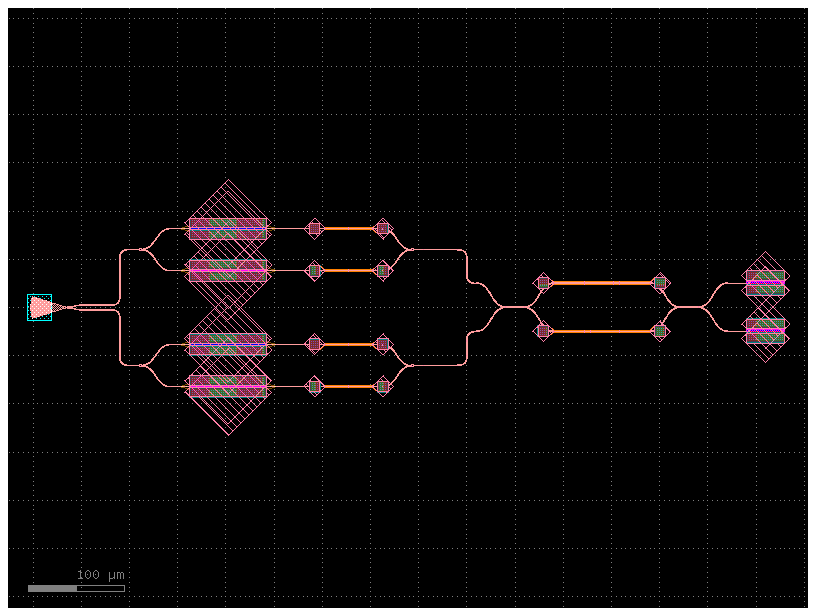

In [3]:
c=PIM_single_unit1(gap_between_modulators=120,min_bend_radius=10)
c.plot_klayout()
c.show()

In [ ]:
c.ports

In [ ]:
ep=(
    "detector1_top_e1",
    "detector1_top_e3",
    "detector1_bot_e1",
    "detector1_bot_e3",
    "detector2_top_e1",
    "detector2_top_e3",
    "detector2_bot_e1",
    "detector2_bot_e3", 

    "tu_to_tl_e1",
    "tu_to_tr_e3",
    "tu_to_bl_e4",
    "tu_to_br_e4",

    "mzm1_to_tl_e1",
    "mzm1_to_tr_e3",
    "mzm1_to_bl_e4",
    "mzm1_to_br_e4",
    "mzm1_eo_tp_e1",
    "mzm1_eo_tp_e3",
    "mzm1_eo_tn_e1",
    "mzm1_eo_tn_e3",
    "mzm1_eo_bp_e1",
    "mzm1_eo_bp_e3",
    "mzm1_eo_bn_e1",
    "mzm1_eo_bn_e3",

    "mzm2_to_tl_e1",
    "mzm2_to_tr_e3",
    "mzm2_to_bl_e4",
    "mzm2_to_br_e4",
    "mzm2_eo_tp_e1",
    "mzm2_eo_tp_e3",
    "mzm2_eo_tn_e1",
    "mzm2_eo_tn_e3",
    "mzm2_eo_bp_e1",
    "mzm2_eo_bp_e3",
    "mzm2_eo_bn_e1",
    "mzm2_eo_bn_e3",
)

ep1=(
    "detector1_top_e1",
    "detector1_top_e3",
    "detector1_bot_e1",
    "detector1_bot_e3",
    # "detector2_top_e1",
    # "detector2_top_e3",
    # "detector2_bot_e1",
    # "detector2_bot_e3", 

    "tu_to_tl_e1",
    "tu_to_tr_e3",
    # "tu_to_bl_e4",
    # "tu_to_br_e4",

    "mzm1_to_tl_e1",
    "mzm1_to_tr_e3",
    "mzm1_to_bl_e4",
    "mzm1_to_br_e4",
    "mzm1_eo_tp_e1",
    "mzm1_eo_tp_e3",
    "mzm1_eo_tn_e1",
    "mzm1_eo_tn_e3",
    "mzm1_eo_bp_e1",
    "mzm1_eo_bp_e3",
    "mzm1_eo_bn_e1",
    "mzm1_eo_bn_e3",

    # "mzm2_to_tl_e1",
    # "mzm2_to_tr_e3",
    # "mzm2_to_bl_e4",
    # "mzm2_to_br_e4",
    # "mzm2_eo_tp_e1",
    # "mzm2_eo_tp_e3",
    # "mzm2_eo_tn_e1",
    # "mzm2_eo_tn_e3",
    # "mzm2_eo_bp_e1",
    # "mzm2_eo_bp_e3",
    # "mzm2_eo_bn_e1",
    # "mzm2_eo_bn_e3",
)

ep2=(
    # "detector1_top_e1",
    # "detector1_top_e3",
    # "detector1_bot_e1",
    # "detector1_bot_e3",
    "detector2_top_e1",
    "detector2_top_e3",
    "detector2_bot_e1",
    "detector2_bot_e3", 

    # "tu_to_tl_e1",
    # "tu_to_tr_e3",
    "tu_to_bl_e4",
    "tu_to_br_e4",

    # "mzm1_to_tl_e1",
    # "mzm1_to_tr_e3",
    # "mzm1_to_bl_e4",
    # "mzm1_to_br_e4",
    # "mzm1_eo_tp_e1",
    # "mzm1_eo_tp_e3",
    # "mzm1_eo_tn_e1",
    # "mzm1_eo_tn_e3",
    # "mzm1_eo_bp_e1",
    # "mzm1_eo_bp_e3",
    # "mzm1_eo_bn_e1",
    # "mzm1_eo_bn_e3",

    "mzm2_to_tl_e1",
    "mzm2_to_tr_e3",
    "mzm2_to_bl_e4",
    "mzm2_to_br_e4",
    "mzm2_eo_tp_e1",
    "mzm2_eo_tp_e3",
    "mzm2_eo_tn_e1",
    "mzm2_eo_tn_e3",
    "mzm2_eo_bp_e1",
    "mzm2_eo_bp_e3",
    "mzm2_eo_bn_e1",
    "mzm2_eo_bn_e3",
)

c=PIM_single_unit1(gap_between_modulators=120,min_bend_radius=10)

cc = gf.routing.add_pads_bot(component=c, port_names=ep2)
ccc = gf.routing.add_pads_top(component=cc, port_names=ep1)
ccc.plot()

In [ ]:
ccc.plot_klayout()
ccc.show()

In [ ]:
c_3d=c.to_3d()
c_3d.show()

In [ ]:
ccc_3d=ccc.to_3d()
ccc_3d.show()

## Pad routing

In [ ]:


ep1=(

    "mzm1_eo_bp_e1",
    "mzm1_eo_bn_e1",

    "mzm1_eo_tn_e1",

    "mzm1_eo_tp_e1",
    "mzm1_eo_tp_e3",

    "mzm1_eo_tn_e3",

    "mzm1_eo_bn_e3", 
    "mzm1_eo_bp_e3",  

    "mzm1_to_bl_e2",

    "mzm1_to_tl_e2",
    "mzm1_to_tr_e2",

    "mzm1_to_br_e2",


    "tu_to_tl_e2",
    "tu_to_tr_e2",

    "detector1_bot_e1",
    "detector1_top_e1",
    "detector1_top_e3",
    "detector1_bot_e3",    

)



ep2=(

    "mzm2_eo_tp_e1",
    "mzm2_eo_tn_e1",
    "mzm2_eo_bn_e1",

    "mzm2_eo_bp_e1",
    "mzm2_eo_bp_e3",

    "mzm2_eo_bn_e3",
    "mzm2_eo_tn_e3", 
    "mzm2_eo_tp_e3",  


    "mzm2_to_tl_e4",
    "mzm2_to_bl_e4",
    "mzm2_to_br_e4",
    "mzm2_to_tr_e4",

    "tu_to_bl_e4",
    "tu_to_br_e4",

    "detector2_top_e1",
    "detector2_bot_e1",
    "detector2_bot_e3", 
    "detector2_top_e3",   

)

@gf.cell
def pim_pads(
    pim: gf.typings.ComponentSpec =PIM_single_unit1,
    pad: gf.typings.ComponentSpec =gf.components.pad,
    pad_array: gf.typings.ComponentSpec = gf.components.pad_array,
    pad_x_position: float = -100.0,
    vertical_gap_pads: float = 600.0,
    top_ports: tuple = ep1,
    bot_ports: tuple = ep2,


):
    

    c= gf.Component()

    pim=gf.get_component(pim)
    pad = gf.get_component(pad)
    pad_array1 = gf.components.pad_array(orientation=270, columns=len(ep1))#gf.component(pad_array,orientation=270, columns=len(ep1))
    pad_array2 = gf.components.pad_array(orientation=90, columns=len(ep2))

    p = c << pim
    p1 = c << pad_array1
    p1.move((pad_x_position,vertical_gap_pads/2))
    p2 = c << pad_array2
    p2.move((pad_x_position,-vertical_gap_pads/2))

    # for pad bundle
    top_pad_ports=dict()
    bottom_pad_ports=dict()

    for pt in ep1:
        top_pad_ports[pt]=pim.ports[pt]

    for pb in ep2:
        bottom_pad_ports[pb]=pim.ports[pb]


    routes_top = gf.routing.get_bundle_electrical(
        p1.ports, top_pad_ports, end_straight_length=60, separation=30,
    )

    for route in routes_top:
        c.add(route.references)

    # routes_bot = gf.routing.get_bundle_electrical(
    #     p2.ports, bottom_pad_ports, end_straight_length=40, separation=20,
    # )

    # for route in routes_bot:
    #     c.add(route.references)


    # n=1
    # for pim_port in ep1:
    #     route1 = gf.routing.get_route_electrical(p1.ports["e1"+str(n)], pim.ports[pim_port], bend="wire_corner")
    #     c.add(route1.references)    
    #     n=n+1   

    # n=1
    # for pim_port in ep2:
    #     route2 = gf.routing.get_route_electrical(p2.ports["e1"+str(n)], pim.ports[pim_port], bend="wire_corner")
    #     c.add(route2.references)   
    #     n=n+1



    return c






In [ ]:
ep1=(

    # "mzm1_eo_bp_e1",
    # "mzm1_eo_bn_e1",

    # "mzm1_eo_tn_e1",

    # "mzm1_eo_tp_e1",
    # "mzm1_eo_tp_e3",

    # "mzm1_eo_tn_e3",

    # "mzm1_eo_bn_e3", 
    # "mzm1_eo_bp_e3",  

    # "mzm1_to_bl_e2",

    # "mzm1_to_tl_e2",
    # "mzm1_to_tr_e2",

    # "mzm1_to_br_e2",


    # "tu_to_tl_e2",
    # "tu_to_tr_e2",

    "detector1_bot_e1",
    "detector1_top_e1",
    "detector1_top_e3",
    "detector1_bot_e3",    

)



ep2=(

    "mzm2_eo_tp_e1",
    "mzm2_eo_tn_e1",
    "mzm2_eo_bn_e1",

    "mzm2_eo_bp_e1",
    "mzm2_eo_bp_e3",

    "mzm2_eo_bn_e3",
    "mzm2_eo_tn_e3", 
    "mzm2_eo_tp_e3",  


    "mzm2_to_tl_e4",
    "mzm2_to_bl_e4",
    "mzm2_to_br_e4",
    "mzm2_to_tr_e4",

    "tu_to_bl_e4",
    "tu_to_br_e4",

    "detector2_top_e1",
    "detector2_bot_e1",
    "detector2_bot_e3", 
    "detector2_top_e3",   

)

c=pim_pads(pad_x_position=-1000,vertical_gap_pads=1000,top_ports=ep1, bot_ports=ep2)

c.plot()